In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import norm

sys.path.append(os.path.realpath('..'))

In [2]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

In [3]:
import numpy as np


class _CheckInputs:
    """ Check if additional arguments are correct """

    def __init__(self, n, p):
        self.n = n
        self.p = p

    def __call__(self, *args):
        if type(self.n) is not int or type(self.p) is not int:
            raise ValueError("n and p must be ints")

        if self.n < 5 or self.p < 1:
            raise ValueError(
                "n must be greater than or equal to 5 and p "
                "must be greater than or equal to than 1"
            )

        for arg in args:
            if arg[1] is float and type(arg[0]) is int:
                continue
            if type(arg[0]) is not arg[1]:
                raise ValueError("Incorrect input variable type")


def _gen_coeffs(p):
    """Calculates coefficients polynomials"""
    return np.array([1 / (i + 1) for i in range(p)]).reshape(-1, 1)


def _random_uniform(n, p, low=-1, high=1):
    """Generate random uniform data"""
    return np.random.uniform(low, high, size=(n, p))


def _calc_eps(n):
    """Calculate noise"""
    return np.random.normal(0, 1, size=(n, 1))


def linear(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate linear data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, 1)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Linear :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}`:

    .. math::

        X &\sim \mathcal{U}(-1, 1)^p \\
        Y &= w^T X + \kappa \epsilon

    Examples
    --------
    >>> from hyppo.sims import linear
    >>> x, y = linear(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 1)
    """
    extra_args = [(noise, bool), (low, float), (high, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    x = _random_uniform(n, p, low, high)
    coeffs = _gen_coeffs(p)
    eps = _calc_eps(n)
    y = x @ coeffs + 1 * noise * eps

    return x, y


def exponential(n, p, noise=False, low=0, high=3):
    r"""
    Simulates univariate or multivariate exponential data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: 0)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: 3)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, 1)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Exponential :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}`:

    .. math::

        X &\sim \mathcal{U}(0, 3)^p \\
        Y &= \exp (w^T X) + 10 \kappa \epsilon

    Examples
    --------
    >>> from hyppo.sims import exponential
    >>> x, y = exponential(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 1)
    """
    extra_args = [(noise, bool), (low, float), (high, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    x = _random_uniform(n, p, low, high)
    coeffs = _gen_coeffs(p)
    eps = _calc_eps(n)
    y = np.exp(x @ coeffs) + 10 * noise * eps

    return x, y


def cubic(n, p, noise=False, low=-1, high=1, cubs=[-12, 48, 128], scale=1 / 3):
    r"""
    Simulates univariate or multivariate cubic data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.
    cubs : list of ints (default: [-12, 48, 128])
        Coefficients of the cubic function where each value corresponds to the
        order of the cubic polynomial.
    scale : float (default: 1/3)
        Scaling center of the cubic.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, 1)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Cubic :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}`:

    .. math::

        X &\sim \mathcal{U}(-1, 1)^p \\
        Y &= 128 \left( w^T X - \frac{1}{3} \right)^3
             + 48 \left( w^T X - \frac{1}{3} \right)^2
             - 12 \left( w^T X - \frac{1}{3} \right)
             + 80 \kappa \epsilon

    Examples
    --------
    >>> from hyppo.sims import cubic
    >>> x, y = cubic(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 1)
    """
    extra_args = [
        (noise, bool),
        (low, float),
        (high, float),
        (cubs, list),
        (scale, float),
    ]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    x = _random_uniform(n, p, low, high)
    coeffs = _gen_coeffs(p)
    eps = _calc_eps(n)

    x_coeffs = x @ coeffs - scale
    y = (
        cubs[2] * x_coeffs ** 3
        + cubs[1] * x_coeffs ** 2
        + cubs[0] * x_coeffs ** 3
        + 80 * noise * eps
    )

    return x, y


def joint_normal(n, p, noise=False):
    r"""
    Simulates univariate or multivariate joint-normal data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, p)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Joint Normal :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`: Let
    :math:`\rho = \frac{1}{2} p`, :math:`I_p` be the identity matrix of size
    :math:`p \times p`, :math:`J_p` be the matrix of ones of size
    :math:`p \times p` and
    :math:`\Sigma = \begin{bmatrix} I_p & \rho J_p \\ \rho J_p & (1 + 0.5\kappa) I_p \end{bmatrix}`. Then,

    .. math::

        (X, Y) \sim \mathcal{N}(0, \Sigma)

    Examples
    --------
    >>> from hyppo.sims import joint_normal
    >>> x, y = joint_normal(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 1)
    """
    if p > 10:
        raise ValueError("Covariance matrix for p>10 is not positive" "semi-definite")

    extra_args = [(noise, bool)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    coeffs = _gen_coeffs(p)
    rho = 1 / (2 * coeffs)
    cov1 = np.concatenate((np.identity(p), rho * np.ones((p, p))), axis=1)
    cov2 = np.concatenate((rho * np.ones((p, p)), np.identity(p)), axis=1)
    covT = np.concatenate((cov1.T, cov2.T), axis=1)

    eps = _calc_eps(n)
    x = np.random.multivariate_normal(np.zeros(2 * p), covT, n)
    y = x[:, 0].reshape(-1, 1) + 0.5 * noise * eps
    x = x[:, :p]

    return x, y


def step(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate step data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, 1)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Step :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}`:

    .. math::

        X &\sim \mathcal{U}(-1, 1)^p \\
        Y &= \mathbb{1}_{w^T X > 0} + \epsilon

    where :math:`\mathbb{1}` is the indicator function.

    Examples
    --------
    >>> from hyppo.sims import step
    >>> x, y = step(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 1)
    """
    extra_args = [(noise, bool), (low, float), (high, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    if p > 1:
        noise = True
    x = _random_uniform(n, p, low, high)
    coeffs = _gen_coeffs(p)
    eps = _calc_eps(n)

    x_coeff = ((x @ coeffs) > 0) * 1
    y = x_coeff + noise * eps

    return x, y


def quadratic(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate quadratic data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, 1)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Quadratic :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}`:

    .. math::

        X &\sim \mathcal{U}(-1, 1)^p \\
        Y &= (w^T X)^2 + 0.5 \kappa \epsilon

    Examples
    --------
    >>> from hyppo.sims import quadratic
    >>> x, y = quadratic(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 1)
    """
    extra_args = [(noise, bool), (low, float), (high, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    x = _random_uniform(n, p, low, high)
    coeffs = _gen_coeffs(p)
    eps = _calc_eps(n)

    x_coeffs = x @ coeffs
    y = x_coeffs ** 2 + 0.5 * noise * eps

    return x, y


def w_shaped(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate quadratic data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, 1)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    W-Shaped :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}`:
    :math:`\mathcal{U}(-1, 1)^p`,

    .. math::

        X &\sim \mathcal{U}(-1, 1)^p \\
        Y &= \left[ \left( (w^T X)^2 - \frac{1}{2} \right)^2
                            + \frac{w^T U}{500} \right] + 0.5 \kappa \epsilon

    Examples
    --------
    >>> from hyppo.sims import w_shaped
    >>> x, y = w_shaped(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 1)
    """
    extra_args = [(noise, bool), (low, float), (high, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    x = _random_uniform(n, p, low, high)
    u = _random_uniform(n, p, 0, 1)
    coeffs = _gen_coeffs(p)
    eps = _calc_eps(n)

    x_coeffs = x @ coeffs
    u_coeffs = u @ coeffs
    y = 4 * ((x_coeffs ** 2 - 0.5) ** 2 + u_coeffs / 500) + 0.5 * noise * eps

    return x, y


def spiral(n, p, noise=False, low=0, high=5):
    r"""
    Simulates univariate or multivariate spiral data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: 0)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: 5)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, 1)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Spiral :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}`:
    :math:`U \sim \mathcal{U}(0, 5)`, :math:`\epsilon \sim \mathcal{N}(0, 1)`

    .. math::

        X_{|d|} &= U \sin(\pi U) \cos^d(\pi U)\ \mathrm{for}\ d = 1,...,p-1 \\
        X_{|p|} &= U \cos^p(\pi U) \\
        Y &= U \sin(\pi U) + 0.4 p \epsilon

    Examples
    --------
    >>> from hyppo.sims import spiral
    >>> x, y = spiral(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 1)
    """
    extra_args = [(noise, bool), (low, float), (high, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    coeffs = _gen_coeffs(p)
    if p > 1:
        noise = True
    rx = _random_uniform(n, p=1, low=low, high=high)
    ry = rx
    rx = np.repeat(rx, p, axis=1)
    z = rx
    x = np.zeros((n, p))
    x[:, 0] = np.cos(z[:, 0] * np.pi)
    for i in range(p - 1):
        x[:, i + 1] = x[:, i] * np.cos(z[:, i+1] * np.pi)
        x[:, i] = x[:, i] * np.sin(z[:, i+1] * np.pi)
    x = rx * x
    y = ry * np.sin(z @ coeffs * np.pi)

    eps = _calc_eps(n)
    y = y + 0.4 * p * noise * eps

    return x, y


def uncorrelated_bernoulli(n, p, noise=False, prob=0.5):
    r"""
    Simulates univariate or multivariate uncorrelated Bernoulli data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    prob : float, (default: 0.5)
        The probability of the bernoulli distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, 1)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Uncorrelated Bernoulli :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}`:
    :math:`U \sim \mathcal{B}(0.5)`, :math:`\epsilon_1 \sim \mathcal{N}(0, I_p)`,
    :math:`\epsilon_2 \sim \mathcal{N}(0, 1)`,

    .. math::

        X &= \mathcal{B}(0.5)^p + 0.5 \epsilon_1 \\
        Y &= (2U - 1) w^T X + 0.5 \epsilon_2

    Examples
    --------
    >>> from hyppo.sims import uncorrelated_bernoulli
    >>> x, y = uncorrelated_bernoulli(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 1)
    """
    extra_args = [(noise, bool), (prob, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    binom = np.random.binomial(1, prob, size=(n, 1))
    sig = np.identity(p)
    gauss_noise = np.random.multivariate_normal(np.zeros(p), sig, size=n)

    x = np.random.binomial(1, prob, size=(n, p)) + 0.5 * noise * gauss_noise
    coeffs = _gen_coeffs(p)

    eps = _calc_eps(n)
    x_coeffs = x @ coeffs
    y = binom * 2 - 1
    y = np.multiply(x_coeffs, y) + 0.5 * noise * eps

    return x, y


def logarithmic(n, p, noise=False):
    r"""
    Simulates univariate or multivariate logarithmic data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, p)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Logarithmic :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`:
    :math:`\epsilon \sim \mathcal{N}(0, I_p)`,

    .. math::

        X &\sim \mathcal{N}(0, I_p) \\
        Y_{|d|} &= 2 \log_2 (|X_{|d|}|) + 3 \kappa \epsilon_{|d|}
                   \ \mathrm{for}\ d = 1, ..., p

    Examples
    --------
    >>> from hyppo.sims import logarithmic
    >>> x, y = logarithmic(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 2)
    """
    extra_args = [(noise, bool)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    coeffs = _gen_coeffs(p)
    sig = np.identity(p)
    x = np.random.multivariate_normal(np.zeros(p), sig, size=n)
    eps = _calc_eps(n)

    y = np.log(x ** 2) + 3 * noise * eps
    y = y @ coeffs #y[:, 0].reshape(-1, 1)

    return x, y


def fourth_root(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate fourth root data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, 1)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Fourth Root :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}`:

    .. math::

        X &\sim \mathcal{U}(-1, 1)^p \\
        Y &= |w^T X|^\frac{1}{4} + \frac{\kappa}{4} \epsilon

    Examples
    --------
    >>> from hyppo.sims import fourth_root
    >>> x, y = fourth_root(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 1)
    """
    extra_args = [(noise, bool), (low, float), (high, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    x = _random_uniform(n, p, low, high)
    eps = _calc_eps(n)
    coeffs = _gen_coeffs(p)

    x_coeffs = x @ coeffs
    y = np.abs(x_coeffs) ** 0.25 + 0.25 * noise * eps

    return x, y


def _sin(n, p, noise=False, low=-1, high=1, period=4*np.pi):
    """Helper function to calculate sine simulation"""
    extra_args = [(noise, bool), (low, float), (high, float), (period, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    coeffs = _gen_coeffs(p).reshape(-1)
    x = _random_uniform(n, p, low, high) * np.flip(coeffs)
    if p > 1 or noise:
        sig = np.identity(p)
        v = np.random.multivariate_normal(np.zeros(p), sig, size=n)
        x = x + 0.02 * p * v
    eps = _calc_eps(n)

    if period == 4 * np.pi:
        cc = 1
    else:
        cc = 0.5

    y = np.sin(x * period) + cc * noise * eps # @ coeffs * period) + cc * noise * eps

    return x, y


def sin_four_pi(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate sine 4 :math:`\pi` data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, p)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Sine 4:math:`\pi` :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`:
    :math:`U \sim \mathcal{U}(-1, 1)`, :math:`V \sim \mathcal{N}(0, 1)^p`,
    :math:`\theta = 4 \pi`,

    .. math::

        X_{|d|} &= U + 0.02 p V_{|d|}\ \mathrm{for}\ d = 1, ..., p \\
        Y &= \sin (\theta X) + \kappa \epsilon

    Examples
    --------
    >>> from hyppo.sims import sin_four_pi
    >>> x, y = sin_four_pi(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 2)
    """
    return _sin(n, p, noise=noise, low=low, high=high, period=4 * np.pi)


def sin_sixteen_pi(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate sine 16 :math:`\pi` data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, p)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Sine 16:math:`\pi` :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`:
    :math:`U \sim \mathcal{U}(-1, 1)`, :math:`V \sim \mathcal{N}(0, 1)^p`,
    :math:`\theta = 16 \pi`,

    .. math::

        X_{|d|} &= U + 0.02 p V_{|d|}\ \mathrm{for}\ d = 1, ..., p \\
        Y &= \sin (\theta X) + \kappa \epsilon

    Examples
    --------
    >>> from hyppo.sims import sin_sixteen_pi
    >>> x, y = sin_sixteen_pi(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 2)
    """
    return _sin(n, p, noise=noise, low=low, high=high, period=16 * np.pi)


def _square_diamond(n, p, noise=False, low=-1, high=1, period=-np.pi / 2):
    """Helper function to calculate square/diamond simulation"""
    extra_args = [(noise, bool), (low, float), (high, float), (period, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    coeffs = _gen_coeffs(p).reshape(-1)
    u = _random_uniform(n, p, low, high)
    v = _random_uniform(n, p, low, high)
    sig = np.identity(p)
    gauss_noise = np.random.multivariate_normal(np.zeros(p), sig, size=n)

    x = u * np.cos(period) + v * np.sin(period) + 0.05 * np.flip(coeffs) * gauss_noise
    y = -u * coeffs * np.sin(period) + v * coeffs * np.cos(period)

    return x, y


def square(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate square data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, p)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Square :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`:
    :math:`U \sim \mathcal{U}(-1, 1)`, :math:`V \sim \mathcal{N}(0, 1)^p`,
    :math:`\theta = -\frac{\pi}{8}`,

    .. math::

        X_{|d|} &= U \cos(\theta) + V \sin(\theta) + 0.05 p \epsilon_{|d|}\ \mathrm{for}\ d = 1, ..., p \\
        Y_{|d|} &= -U \sin(\theta) + V \cos(\theta)

    Examples
    --------
    >>> from hyppo.sims import square
    >>> x, y = square(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 2)
    """
    return _square_diamond(n, p, noise=noise, low=low, high=high, period=-np.pi / 8)


def two_parabolas(n, p, noise=False, low=-1, high=1, prob=0.5):
    r"""
    Simulates univariate or multivariate two parabolas data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.
    prob : float, (default: 0.5)
        The probability of the bernoulli distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, 1)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Two Parabolas :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`:

    .. math::

        X &\sim \mathcal{U}(-1, 1)^p \\
        Y &= ((w^T X)^2 + 2 \kappa \epsilon) \times \left( U = \frac{1}{2} \right)

    Examples
    --------
    >>> from hyppo.sims import two_parabolas
    >>> x, y = two_parabolas(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 2)
    """
    extra_args = [(noise, bool), (low, float), (high, float), (prob, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    x = _random_uniform(n, p, low, high)
    coeffs = _gen_coeffs(p)
    u = np.random.binomial(1, prob, size=(n, 1))
    rand_noise = _random_uniform(n, 1, low=0, high=1)

    x_coeffs = x @ coeffs
    y = (x_coeffs ** 2 + 2 * noise * rand_noise) * (u - 0.5)

    return x, y


def _circle_ellipse(n, p, noise=False, low=-1, high=1, radius=1):
    """Helper function to calculate circle/ellipse simulation"""
    extra_args = [(noise, bool), (low, float), (high, float), (radius, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    coeffs = _gen_coeffs(p)
    if p > 1:
        noise = True
    x = _random_uniform(n, p, low, high)
    rx = radius * np.ones((n, p))
    unif = _random_uniform(n, p, low, high)
    sig = np.identity(p)
    gauss_noise = np.random.multivariate_normal(np.zeros(p), sig, size=n)

    ry = np.ones((n, 1))
    x[:, 0] = np.cos(unif[:, 0] * np.pi)
    for i in range(p - 1):
        x[:, i + 1] = x[:, i] * np.cos(unif[:, i + 1] * np.pi)
        x[:, i] = x[:, i] * np.sin(unif[:, i + 1] * np.pi)

    x = rx * x + 0.4 * noise * rx * gauss_noise
    y = ry * np.sin(unif @ coeffs * np.pi)

    return x, y


def circle(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate circle data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, p)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Circle :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`:
    :math:`U \sim \mathcal{U}(-1, 1)^p`, :math:`\epsilon \sim \mathcal{N}(0, I_p)`,
    :math:`r = 1`,

    .. math::

        X_{|d|} &= r \left( \sin(\pi U_{|d+1|}) \prod_{j=1}^d \cos(\pi U_{|j|}) + 0.4 \epsilon_{|d|} \right)\ \mathrm{for}\ d = 1, ..., p-1 \\
        X_{|d|} &= r \left( \prod_{j=1}^p \cos(\pi U_{|j|}) + 0.4 \epsilon_{|p|} \right) \\
        Y_{|d|} &= \sin(\pi U_{|1|})

    Examples
    --------
    >>> from hyppo.sims import circle
    >>> x, y = circle(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 2)
    """
    return _circle_ellipse(n, p, noise=noise, low=low, high=high, radius=1)


def ellipse(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate ellipse data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, p)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Ellipse :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`:
    :math:`U \sim \mathcal{U}(-1, 1)^p`, :math:`\epsilon \sim \mathcal{N}(0, I_p)`,
    :math:`r = 5`,

    .. math::

        X_{|d|} &= r \left( \sin(\pi U_{|d+1|}) \prod_{j=1}^d \cos(\pi U_{|j|}) + 0.4 \epsilon_{|d|} \right)\ \mathrm{for}\ d = 1, ..., p-1 \\
        X_{|d|} &= r \left( \prod_{j=1}^p \cos(\pi U_{|j|}) + 0.4 \epsilon_{|p|} \right) \\
        Y_{|d|} &= \sin(\pi U_{|1|})

    Examples
    --------
    >>> from hyppo.sims import ellipse
    >>> x, y = ellipse(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 2)
    """
    return _circle_ellipse(n, p, noise=noise, low=low, high=high, radius=5)


def diamond(n, p, noise=False, low=-1, high=1):
    r"""
    Simulates univariate or multivariate diamond data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    noise : bool, (default: False)
        Whether or not to include noise in the simulation.
    low : float, (default: -1)
        The lower limit of the uniform distribution simulated from.
    high : float, (default: -1)
        The upper limit of the uniform distribution simulated from.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, p)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Diamond :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`:
    :math:`U \sim \mathcal{U}(-1, 1)`, :math:`V \sim \mathcal{N}(0, 1)^p`,
    :math:`\theta = -\frac{\pi}{4}`,

    .. math::

        X_{|d|} &= U \cos(\theta) + V \sin(\theta) + 0.05 p \epsilon_{|d|}\ \mathrm{for}\ d = 1, ..., p \\
        Y_{|d|} &= -U \sin(\theta) + V \cos(\theta)

    Examples
    --------
    >>> from hyppo.sims import diamond
    >>> x, y = diamond(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 2)
    """
    return _square_diamond(n, p, noise=noise, low=low, high=high, period=-np.pi / 4)


def multiplicative_noise(n, p):
    r"""
    Simulates univariate or multivariate multiplicative noise data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, p)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Multiplicative Noise :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`:
    :math:`\U \sim \mathcal{N}(0, I_p)`,

    .. math::

        X &\sim \mathcal{N}(0, I_p) \\
        Y_{|d|} &= U_{|d|} X_{|d|}\ \mathrm{for}\ d = 1, ..., p

    Examples
    --------
    >>> from hyppo.sims import multiplicative_noise
    >>> x, y = multiplicative_noise(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 2)
    """
    extra_args = []
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    coeffs = _gen_coeffs(p)
    sig = np.identity(p)
    x = np.random.multivariate_normal(np.zeros(p), sig, size=n)
    y = np.random.multivariate_normal(np.zeros(p), sig, size=n)
    y = np.multiply(x, y)
    y = y @ coeffs # y[:, 0].reshape(-1, 1)

    return x, y


def multimodal_independence(n, p, prob=0.5, sep1=3, sep2=2):
    r"""
    Simulates univariate or multimodal independence data.

    Parameters
    ----------
    n : int
        The number of samples desired by the simulation.
    p : int
        The number of dimensions desired by the simulation.
    prob : float, (default: 0.5)
        The probability of the bernoulli distribution simulated from.
    sep1, sep2: float, (default: 3, 2)
        The separation between clusters of normally distributed data.

    Returns
    -------
    x, y : ndarray
        Simulated data matrices. `x` and `y` have shapes `(n, p)` and `(n, p)`
        where `n` is the number of samples and `p` is the number of
        dimensions.

    Notes
    -----
    Multimodal Independence :math:`(X, Y) \in \mathbb{R}^p \times \mathbb{R}^p`:
    :math:`U \sim \mathcal{N}(0, I_p)`, :math:`V \sim \mathcal{N}(0, I_p)`,
    :math:`U^\prime \sim \mathcal{B}(0.5)^p`, :math:`V^\prime \sim \mathcal{B}(0.5)^p`,

    .. math::

        X &= \frac{U}{3} + 2 U^\prime - 1 \\
        Y &= \frac{V}{3} + 2 V^\prime - 1

    Examples
    --------
    >>> from hyppo.sims import multimodal_independence
    >>> x, y = multimodal_independence(100, 2)
    >>> print(x.shape, y.shape)
    (100, 2) (100, 2)
    """
    extra_args = [(prob, float), (sep1, float), (sep2, float)]
    check_in = _CheckInputs(n, p)
    check_in(*extra_args)

    sig = np.identity(p)
    u = np.random.multivariate_normal(np.zeros(p), sig, size=n)
    v = np.random.multivariate_normal(np.zeros(p), sig, size=n)
    u_2 = np.random.binomial(1, prob, size=(n, p))
    v_2 = np.random.binomial(1, prob, size=(n, p))

    x = u / sep1 + sep2 * u_2 - 1
    y = v / sep1 + sep2 * v_2 - 1
    y = y[:, 0].reshape(-1, 1)

    return x, y


_SIMULATIONS = {
    "linear": linear,
    "exponential": exponential,
    "cubic": cubic,
    "joint_normal": joint_normal,
    "step": step,
    "quadratic": quadratic,
    "w_shaped": w_shaped,
    "spiral": spiral,
    "uncorrelated_bernoulli": uncorrelated_bernoulli,
    "logarithmic": logarithmic,
    "fourth_root": fourth_root,
    "sin_four_pi": sin_four_pi,
    "sin_sixteen_pi": sin_sixteen_pi,
    "square": square,
    "two_parabolas": two_parabolas,
    "circle": circle,
    "ellipse": ellipse,
    "diamond": diamond,
    "multiplicative_noise": multiplicative_noise,
    "multimodal_independence": multimodal_independence
}


def indep_sim(sim, n, p, **kwargs):
    """
    Allows choice for which simulation the user
    """
    if sim not in _SIMULATIONS.keys():
        raise ValueError("sim_name must be one of the following: {}".format(list(_SIMULATIONS.keys())))
    else:
        sim = _SIMULATIONS[sim]

    return sim(n, p, **kwargs)

In [4]:
# constants
REPS = 100
DIM = 5
FOREST_SIZE = 5000
SIM_SIZE = 200

SIMULATIONS = [
    "linear",
    "exponential",
    "cubic",
    "joint_normal",
    "step",
    "quadratic",
    "w_shaped",
    "spiral",
    "uncorrelated_bernoulli",
    "logarithmic",
    "fourth_root",
    "sin_four_pi",
    "sin_sixteen_pi",
    "square",
    "two_parabolas",
    "circle",
    "ellipse",
    "diamond",
    "multiplicative_noise",
    "multimodal_independence",
]

In [5]:
def tree_import(sim):
    forest = RandomForestRegressor(FOREST_SIZE)
    x, y = indep_sim(sim, SIM_SIZE, DIM)
    if y.shape[1] == 1:
        y = y.ravel()

    forest.fit(x, y)
    importances = forest.feature_importances_
    importances -= np.min(importances)
    importances /= np.max(importances)
    
    return importances

def estimate_featimport(sim_name, rep):
    est_featimpt = tree_import(sim_name)
    np.savetxt('../kmerf/data/{}_{}.csv'.format(sim_name, rep), est_featimpt, delimiter=',')
    
    return est_featimpt

In [ ]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_featimport)(sim_name, rep) for sim_name in SIMULATIONS for rep in range(REPS)]
)

In [10]:
def plot_featimport_alltree():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    plt.suptitle("Feature Importances", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim_name = SIMULATIONS[count]
            
            all_impt = np.zeros((REPS, DIM))
            for rep in range(REPS):
                forest_impt = np.genfromtxt('../kmerf/data/{}_{}.csv'.format(sim_name, rep), delimiter=',')
                all_impt[rep, :] = forest_impt
                col.plot(range(1, DIM + 1), forest_impt, "#d9d9d9", lw=1, alpha=0.5, label="")
            mean_impt = np.mean(all_impt, axis=0)
            col.plot(range(1, DIM + 1), mean_impt, color="#525252", lw=5, label="Averaged Data")
            
            col.set_xticks([])
            if i == 3:
                col.set_xticks([1, 5])
            col.set_xlim([1, 5])
            col.set_ylim([0, 1])
            col.set_yticks([])
            if j == 0:
                col.set_yticks([0, 1])
            col.set_title(sim_name)
            
    fig.text(0.5, 0.07, 'Dimension', ha='center')
    fig.text(0.07, 0.5, 'Normalized Feature Importance', va='center', rotation='vertical')
    plt.subplots_adjust(hspace=.50, wspace=.40)
    plt.savefig('../kmerf/figs/rf_importance.pdf', transparent=True, bbox_inches='tight')

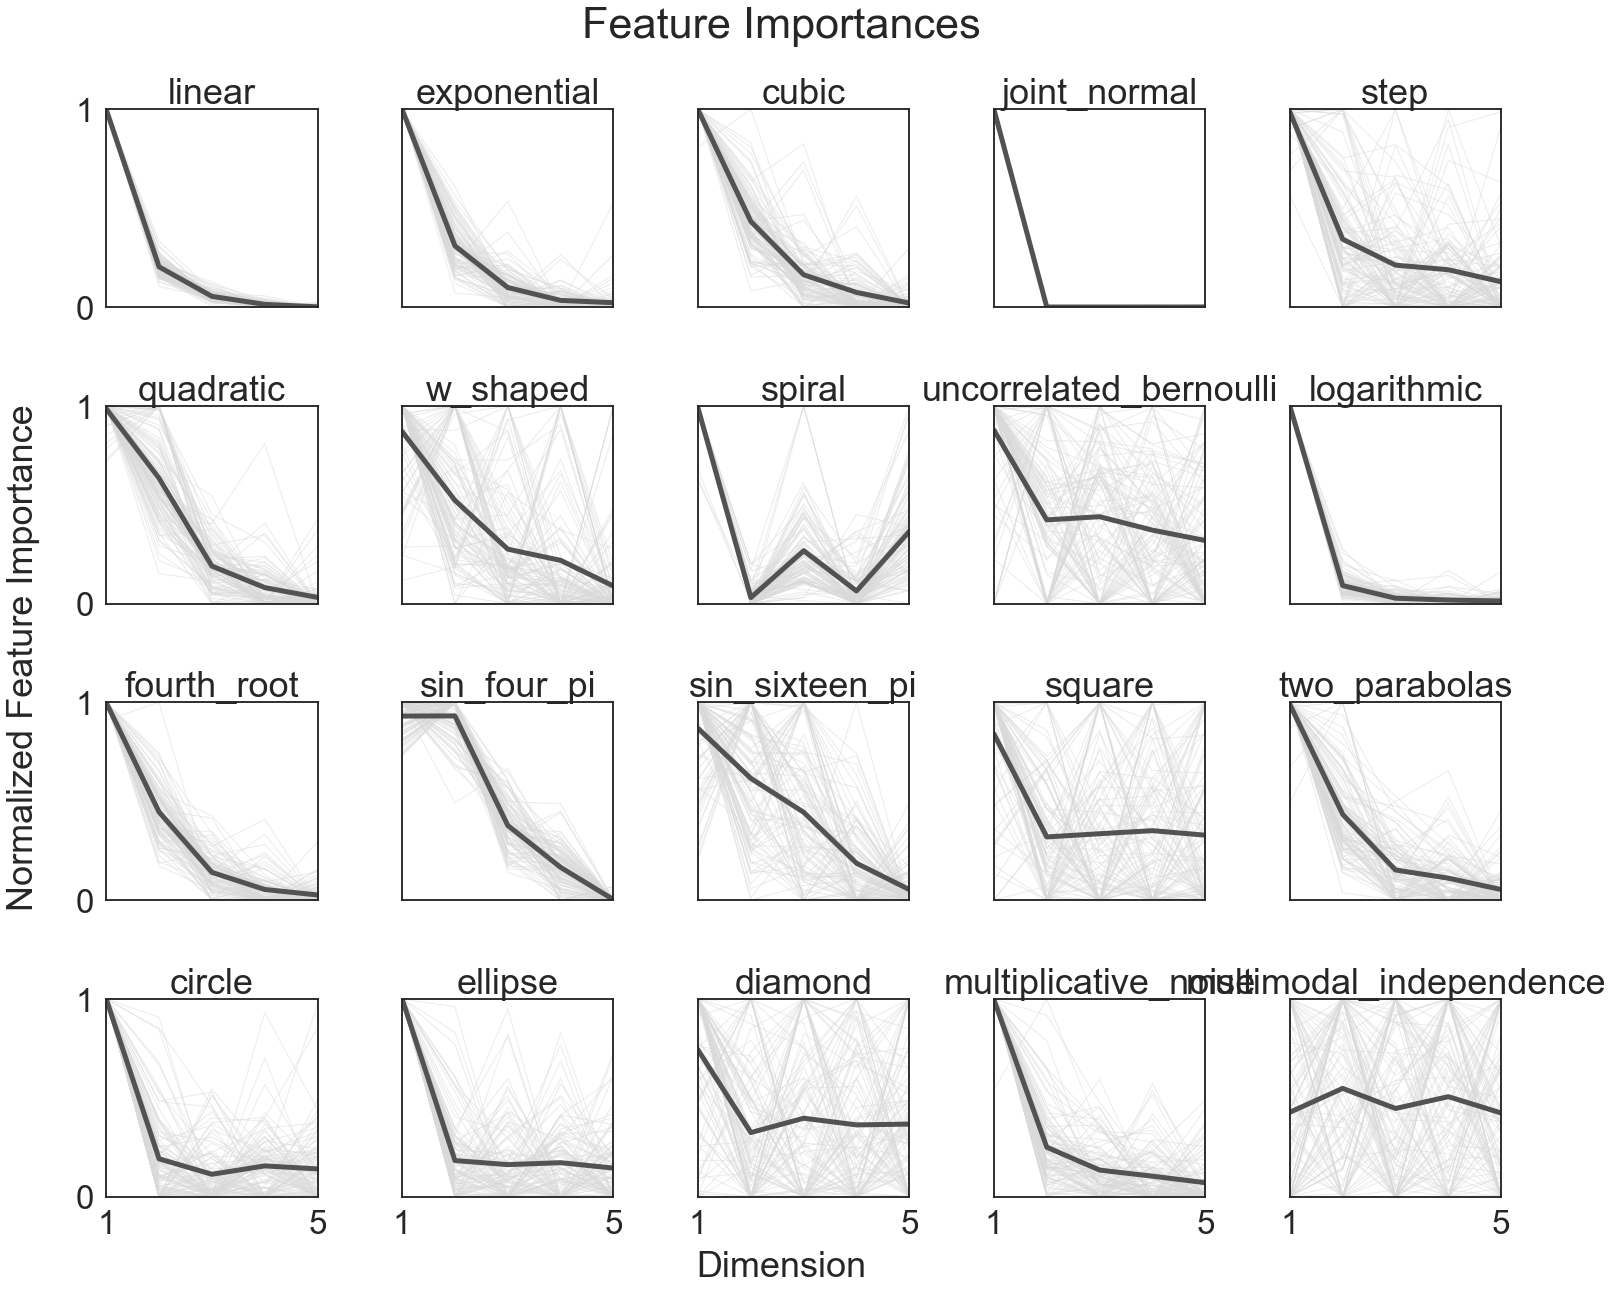

In [11]:
plot_featimport_alltree()

In [15]:
def plot_featimport_confint():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    plt.suptitle("Feature Importances", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim_name = SIMULATIONS[count]
            
            all_impt = np.zeros((REPS, DIM))
            for rep in range(REPS):
                forest_impt = np.genfromtxt('../kmerf/data/{}_{}.csv'.format(sim_name, rep), delimiter=',')
                all_impt[rep, :] = forest_impt
            mean_impt = np.mean(all_impt, axis=0)
            mean_impt -= np.min(mean_impt)
            mean_impt /= np.max(mean_impt)
            low, high = norm.interval(0.95, loc=mean_impt, scale=np.std(mean_impt, axis=0)/np.sqrt(REPS))
            col.plot(range(1, DIM + 1), mean_impt, color="#525252", lw=5, label="Averaged Data")
            col.fill_between(range(1, DIM + 1), low, high, color="#d9d9d9")
            
            col.set_xticks([])
            if i == 3:
                col.set_xticks([1, 5])
            col.set_xlim([1, 5])
            col.set_ylim([0, 1])
            col.set_yticks([])
            if j == 0:
                col.set_yticks([0, 1])
            col.set_ylabel('')    
            col.set_xlabel('')
            col.set_title(sim_title[count])
            
    fig.text(0.5, 0.07, 'Dimension (Sorted by Feature Importance)', ha='center')
    fig.text(0.07, 0.5, 'Estimated Feature Importance', va='center', rotation='vertical')
    plt.subplots_adjust(hspace=.50, wspace=.40)
    plt.savefig('../kmerf/figs/rf_importance.pdf', transparent=True, bbox_inches='tight')

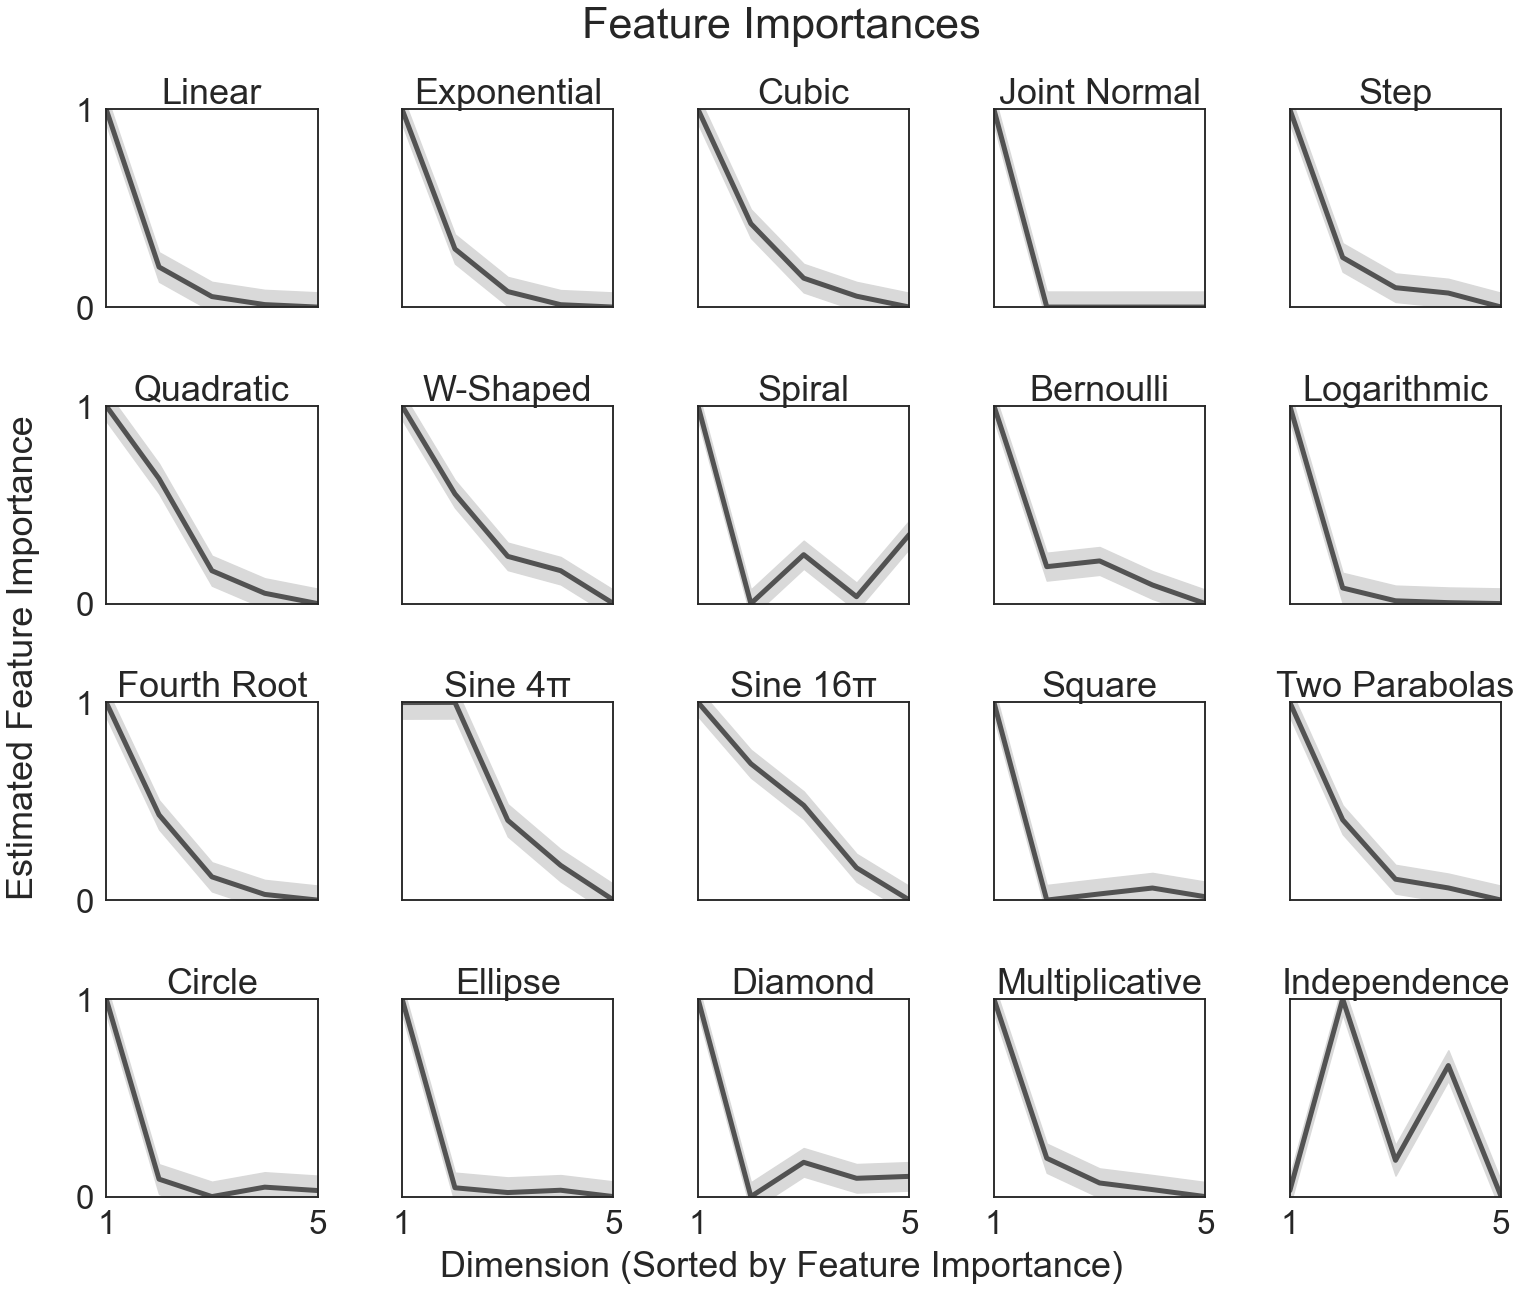

In [16]:
plot_featimport_confint()